In [1]:
import numpy as np
import freegs
from freegs.plotting import plotConstraints
from freegs.critical import find_critical
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

%load_ext autoreload
%autoreload 2

In [2]:
# import pickle
# with open('../freegsnke/Fiesta_full_passive.pk', 'rb') as f:
#     data = pickle.load(f)
# passive_coils = []
# # R, Z, dR, dZ, resistivity
# for l in data[0]:
#     passive_coils.append({
#         "R": l[0],
#         "Z": l[1],
#         "dR": l[2],
#         "dZ": l[3],
#         "resistivity": l[4]
#     })

# pickle.dump(passive_coils, open("passive_coils.pk", "wb"))


In [3]:
# rwall = [1.56442 , 1.73298 , 1.34848 , 1.0882  , 0.902253, 0.903669,
#     0.533866, 0.538011, 0.332797, 0.332797, 0.334796, 0.303115,
#     0.305114, 0.269136, 0.271135, 0.260841, 0.260841, 0.271135,
#     0.269136, 0.305114, 0.303115, 0.334796, 0.332797, 0.332797,
#     0.538598, 0.534469, 0.90563 , 0.904219, 1.0882  , 1.34848 ,
#     1.73018 , 1.56442 , 1.37999 , 1.37989 , 1.19622 , 1.19632 ,
#     1.05537 , 1.05528 , 0.947502, 0.905686, 0.899143, 0.883388,
#     0.867681, 0.851322, 0.833482, 0.826063, 0.822678, 0.821023,
#     0.820691, 0.822887, 0.827573, 0.839195, 0.855244, 0.877567,
#     0.899473, 1.18568 , 1.279   , 1.296   , 1.521   , 1.521   ,
#     1.8     , 1.8     , 1.521   , 1.521   , 1.296   , 1.279   ,
#     1.18568 , 0.899473, 0.877567, 0.855244, 0.839195, 0.827573,
#     0.822887, 0.820691, 0.821023, 0.822678, 0.826063, 0.833482,
#     0.851322, 0.867681, 0.883388, 0.899143, 0.905686, 0.947502,
#     1.05528 , 1.05537 , 1.19632 , 1.19622 , 1.37989 , 1.37999 ,
#     1.56442 ]

# zwall = [ 1.56424 ,  1.67902 ,  2.06041 ,  2.05946 ,  1.87565 ,  1.87424 ,
#     1.50286 ,  1.49874 ,  1.29709 ,  1.094   ,  1.094   ,  0.8475  ,
#     0.8475  ,  0.565   ,  0.565   ,  0.495258, -0.507258, -0.577   ,
#     -0.577   , -0.8595  , -0.8595  , -1.106   , -1.106   , -1.30909 ,
#     -1.5099  , -1.51403 , -1.88406 , -1.88547 , -2.06614 , -2.06519 ,
#     -1.68099 , -1.56884 , -1.57688 , -1.57673 , -1.58475 , -1.5849  ,
#     -1.59105 , -1.59091 , -1.59561 , -1.59556 , -1.59478 , -1.59026 ,
#     -1.58087 , -1.56767 , -1.54624 , -1.52875 , -1.51517 , -1.49624 ,
#     -1.47724 , -1.44582 , -1.41923 , -1.38728 , -1.35284 , -1.3221  ,
#     -1.30018 , -1.0138  , -0.8423  , -0.8202  , -0.8202  , -0.25    ,
#     -0.25    ,  0.25    ,  0.25    ,  0.8156  ,  0.8156  ,  0.8377  ,
#     1.0092  ,  1.29558 ,  1.3175  ,  1.34824 ,  1.38268 ,  1.41463 ,
#     1.44122 ,  1.47264 ,  1.49164 ,  1.51057 ,  1.52415 ,  1.54164 ,
#     1.56307 ,  1.57627 ,  1.58566 ,  1.59018 ,  1.59096 ,  1.59101 ,
#     1.58631 ,  1.58645 ,  1.5803  ,  1.58015 ,  1.57213 ,  1.57228 ,
#     1.56424 ]

# wall = []
# for i in range(len(rwall)):
#     wall.append({"R": rwall[i], "Z": zwall[i]})

# pickle.dump(wall, open("wall.pk", "wb"))

In [4]:
# with open('../machine_configs/MAST-U/passive_coils.pk', 'rb') as f:
#     passive_coils = pickle.load(f)
# passive_coils

In [5]:
# with open('../machine_configs/MAST-U/active_coils.pkl', 'rb') as f:
#     active_coils = pickle.load(f)
# active_coils

In [6]:
# %matplotlib notebook

In [4]:
# Create the machine, which specifies coil locations
# and equilibrium, specifying the domain to solve over
# this has to be either
# freegs.machine.MASTU(), in which case:
#tokamak = freegs.machine.MASTU()
# or
# MASTU_coils.MASTU_wpass()
import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"

from freegsnke import machine_config
from freegsnke import build_machine
from freegsnke import faster_shape

tokamak = build_machine.tokamak()


# Creates equilibrium object and initializes it with 
# a "good" solution
# plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed 
                        Rmin=0.1, Rmax=2.0,    # Radial domain
                        Zmin=-2.2, Zmax=2.2,   # Height range
                        #grid resolution can be changed
                        nx=65, ny=65, # Number of grid points
                        # psi=plasma_psi[::2,:])   
                        )  

# Sets desired plasma properties for the 'starting equilibrium'
# values can be changed
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(8.1e3, # Plasma pressure on axis [Pascals]
                            6.2e5, # Plasma current [Amps]
                            0.5, # vacuum f = R*Bt
                            alpha_m = 1.8,
                            alpha_n = 1.2)


# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.6
Zx = 1.1

Rmid = 1.4   # Outboard midplane
Rin = 0.4  # Inboard midplane

xpoints = [(Rx, -Zx-.01),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
    
           # Link inner and outer midplane locations
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),

           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]

eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)
                                    
from freegsnke import GSstaticsolver
NK = GSstaticsolver.NKGSsolver(eq)

Text(0.5, 1.0, 'q profile')

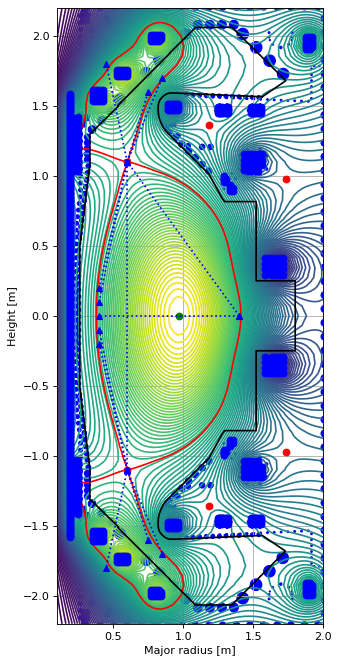

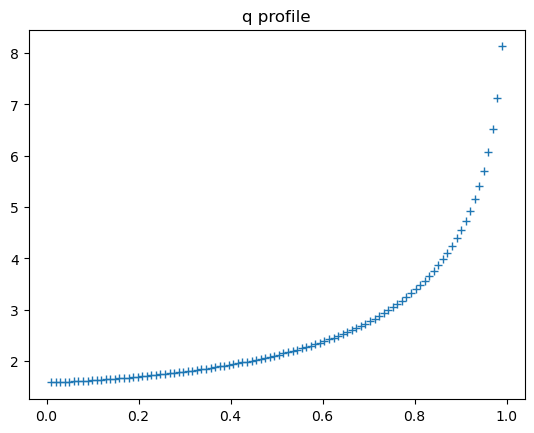

In [5]:
eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False
eq.tokamak['Solenoid'].current = 15000
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)               
eq.tokamak['Solenoid'].current = 40000
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)  
NK.solve(eq, profiles, target_relative_tolerance=1e-8)
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

qprof = eq.q()
plt.figure()
plt.plot(qprof[0], qprof[1], '+')
plt.title('q profile')

In [10]:
# Initialize the evolution object
# This uses the starting equilibrium to get all the geometric constraints/grids etc
from freegsnke import nonlinear_solve
stepping = nonlinear_solve.nl_solver(profiles=profiles, eq=eq, 
                                         max_mode_frequency=10**3.5, 
                                         full_timestep=1e-4, 
                                         plasma_resistivity=1e-7,
                                         extrapolator_input_size=4,
                                         extrapolator_order=1,
                                         plasma_norm_factor=1000,
                                         plasma_domain_mask=None,
                                         nbroad=3,
                                         solution_method='NK_on_psi_and_currents')
# this is the number of independent vessel normal modes (maximum is 699)
print('Input max_mode_frequency corresponds to ', 
       stepping.n_metal_modes, ' independent vessel normal modes')

# In absence of a policy, this calculates the active voltages U_active
# to maintain the currents needed for the equilibrium statically
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils]

Input max_mode_frequency corresponds to  454  independent vessel normal modes


'Step: 49/49'

'current time t = 0.0049'

'current time step dt = 0.0001'

starting: curr residual 11.40368963775819 0.32928668633096525
[0, 'psi_residual', 7.068638367513369e-05]
[0, 'intermediate curr residual', 11.403689651374865, 0.32928668642383396]
[0, 'curr_coeffs = ', array([0.90133522])]
[0, 'full cycle curr residual', 1.1338628312335572, 0.026210129839737008]
[0, 'GS residual: ', 0.04104066229078282]
[1, 'psi_residual', 6.043100689337444e-05]
[1, 'intermediate curr residual', 2.1582172669504844, 0.09356675483863033]
[1, 'curr_coeffs = ', array([0.8246056])]
[1, 'full cycle curr residual', 0.920388806079115, 0.011143950329872622]
[1, 'GS residual: ', 0.03540204297616373]
[2, 'psi_residual', 6.324538174656835e-05]
[2, 'intermediate curr residual', 5.32763496915421, 0.10436262661641982]
[2, 'curr_coeffs = ', array([0.76768734])]
[2, 'full cycle curr residual', 0.41506414339160314, 0.009452197280322752]
[2, 'GS residual: ', 0.0373992250506597]
[3, 'psi_residual', 6.478386787391044e-05]
[3, 'intermediate curr residual', 2.497282352199215, 0.1109693318876

Text(0, 0.5, 'Plasma elongation')

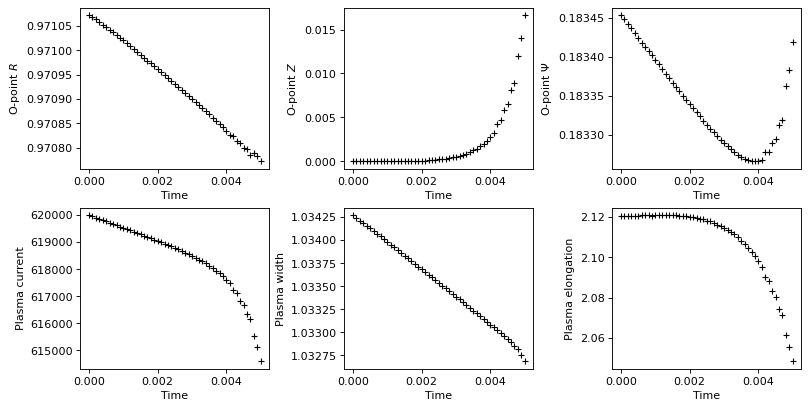

In [11]:
# Example of evolution with constant applied voltages
t = 0
flag = 0
history_times = [t]
t_per_step = []

#use the following to reset stepping.eq1 to a new IC
stepping.initialize_from_ICs(eq, profiles, noise_level=.1, new_seed=True)

history_currents = [stepping.currents_vec]
history_equilibria = [deepcopy(stepping.eq1)]
shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
history_width = [shapes[0]]
history_o_points = shapes[1]
history_elongation = [shapes[2]]
# history_dJs = [stepping.dJ]

counter = 0
max_count = 50
while flag<1 and counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t}')
    display(f'current time step dt = {stepping.dt_step}')
    
    t_start = time.time()

    # flag = stepping.nl_step_nk_curr_GS(active_voltage_vec=U_active, 
    #                                    target_relative_tol_currents=.1,
    #                                    use_extrapolation=False,
    #                                     working_relative_tol_GS=.003,
    #                                     target_relative_unexplained_residual=.5,
    #                                     max_n_directions=5,
    #                                     max_Arnoldi_iterations=5,
    #                                     max_collinearity=.3,
    #                                     step_size_curr=1,
    #                                     scaling_with_n=0,
    #                                     curr_eps=1e-3,
    #                                     clip=3,
    #                                     threshold=1.5,
    #                                     clip_hard=1.5,
    #                                     verbose=True)

    flag = stepping.nl_step_nk_psi_curr(active_voltage_vec=U_active, 
                                        target_relative_tol_currents=.1,
                                        target_relative_tol_GS=.1,
                                        use_extrapolation=True,
                                        working_relative_tol_GS=.003,
                                        target_relative_unexplained_residual=.5,
                                        max_n_directions=4,
                                        max_Arnoldi_iterations=5,
                                        max_collinearity=.3,
                                        step_size_psi=.35,
                                        step_size_curr=1.,
                                        scaling_with_n=0,
                                        relative_tol_for_nk_psi=.02,
                                        blend_GS=.4,
                                        curr_eps=1e-4,
                                        max_no_NK_psi=5.,
                                        clip=10,
                                        threshold=2.,
                                        clip_hard=3.,
                                        verbose=True,)
                                        
   
    t_end = time.time()
    t_per_step.append(t_end-t_start)

    t += stepping.dt_step
    history_times.append(t)
    shapes = faster_shape.shapes_f(stepping.eq2, stepping.profiles2)

    history_currents.append(stepping.currents_vec)
    history_equilibria.append(deepcopy(stepping.eq2))
    history_width.append(shapes[0])
    history_o_points = np.append(history_o_points,shapes[1], axis=0)
    history_elongation.append(shapes[2])
    # history_dJs.append(stepping.dJ)
    counter += 1

history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)


# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1],'k+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1]*stepping.plasma_norm_factor,'k+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

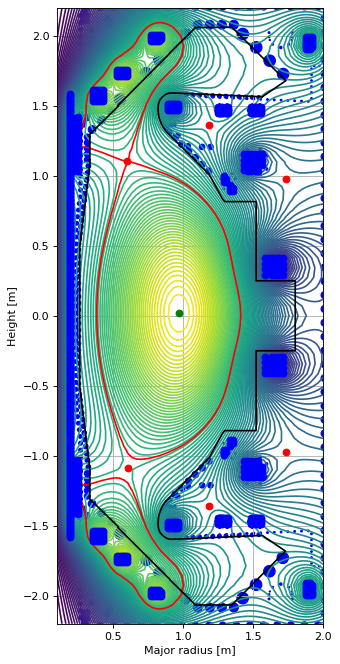

In [13]:
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
history_equilibria[-1].plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);